In [1]:
import math, random
import matplotlib.pyplot as plt
# выполните "pip install hmmlearn" перед выполнением скрипта
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import numpy as np 

# выключили предупреждения hmmlearn
import warnings
warnings.filterwarnings('ignore')

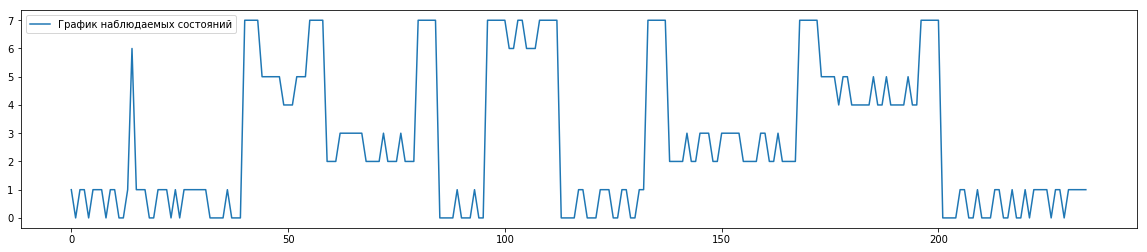

In [2]:
import math, random
import matplotlib.pyplot as plt

with open("./data/transitions.txt") as f:
    observations = [int(x) - 1 for x in f.readlines()]

plt.figure(figsize=(20, 4))
plt.plot(observations)
plt.legend(["График наблюдаемых состояний"])
plt.show()

In [3]:
room_count = 4
location_count = 8

shaped_observations = np.array([observations]).T
# MultinomialHMM - для дискретных наблюдений, в массиве должны быть числа 0..(n-1) без пропусков
algorithm = MultinomialHMM(
    n_components=room_count,  # число внутренних состояний
    algorithm='viterbi',      # алгоритм подбора параметров
    n_iter=100,               # число итераций
    verbose=True)             # выводить отладочную информацию по итерациям

# выполним алгоритм Витерби
model = algorithm.fit(shaped_observations)

         1        -473.0029             +nan
         2        -448.2914         +24.7116
         3        -444.0224          +4.2690
         4        -434.1062          +9.9162
         5        -412.9553         +21.1509
         6        -387.8731         +25.0822
         7        -365.6767         +22.1964
         8        -338.7183         +26.9584
         9        -293.4699         +45.2484
        10        -232.6567         +60.8133
        11        -209.1342         +23.5225
        12        -207.8994          +1.2347
        13        -207.7940          +0.1054
        14        -207.7754          +0.0186
        15        -207.7721          +0.0033


In [4]:
# функция для красивой печати матриц и массивов
def print_matrix(M):
    s = M.shape
    print('\t',end='')
    for j in range(1, s[1]+1):
        print(" [{}] \t".format(j), end='')
    print()
    for i in range(1, s[0]+1):
        print('<{}>'.format(i),end='')
        for j in range(1, s[1]+1):
            print("\t{:.2f}".format(M[i-1,j-1]), end='')
        print()

Вероятности, что находятся в помещении <i> вы будете наблюдать локацию [j]
	 [1] 	 [2] 	 [3] 	 [4] 	 [5] 	 [6] 	 [7] 	 [8] 	
<1>	0.50	0.50	0.00	0.00	0.00	0.00	0.01	0.00
<2>	0.00	0.00	0.00	0.00	0.00	0.00	0.11	0.89
<3>	0.00	0.00	0.00	0.00	0.50	0.50	0.00	0.00
<4>	0.00	0.00	0.61	0.39	0.00	0.00	0.00	0.00

Вероятности перехода из <i> в [j]
	 [1] 	 [2] 	 [3] 	 [4] 	
<1>	0.97	0.03	0.00	0.00
<2>	0.07	0.84	0.04	0.04
<3>	0.00	0.06	0.94	0.00
<4>	0.00	0.04	0.00	0.96


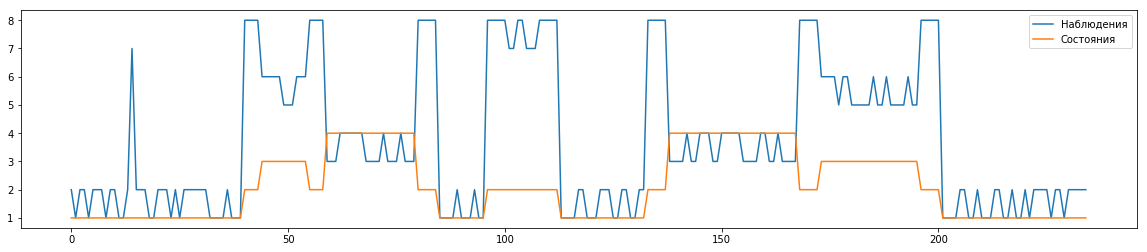

In [5]:
# матрица вероятностей наблюдений
print("Вероятности, что находятся в помещении <i> вы будете наблюдать локацию [j]")
print_matrix(model.emissionprob_)
print()

# матрица переходов
print("Вероятности перехода из <i> в [j]")
print_matrix(model.transmat_)

# обратите внимание, что матрица стремится занять диагональный вид -- 
# на диагонали большие значения. Это потому что состояния в примере достаточно "инертны"

plt.figure(figsize=(20, 4))
plt.plot(shaped_observations+1)
plt.plot(model.predict(shaped_observations)+1)
plt.legend(["Наблюдения", "Состояния"])
plt.show()

Предсказанные состояния: [1 1 1 1 1 1 1 2 4 4 4 4 4 4 4 4 2 3 3 3 3 3 3 2 2 2 2 2 2 2]


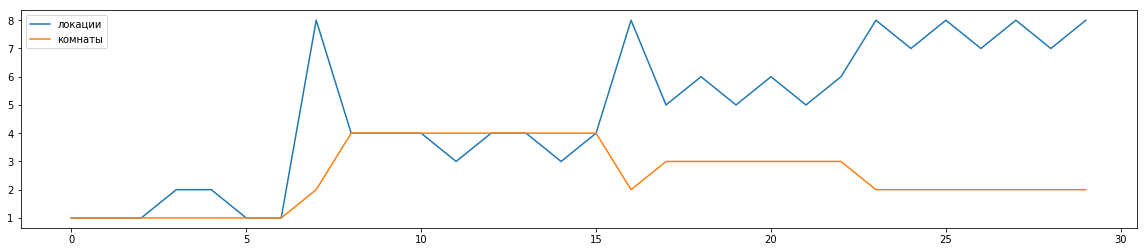

	 [1] 	 [2] 	 [3] 	 [4] 	 [5] 	 [6] 	 [7] 	 [8] 	
<1>	0.01	0.01	0.51	0.33	0.01	0.01	0.02	0.12


In [6]:
# что с этим можно сделать? Например

# 1. По набору наблюдений предсказать состояния
test = [1,1,1,2,2,1,1,8,4,4,4,3,4,4,3,4,8,5,6,5,6,5,6,8,7,8,7,8,7,8]
observ = np.array([[x-1 for x in test]]).T
print("Предсказанные состояния:", model.predict(observ)+1) # +1 для индексации с 1

plt.figure(figsize=(20, 4))
plt.plot(test)
plt.plot(model.predict(observ)+1)
plt.legend(["локации", "комнаты"])
plt.show()

# 2. Вероятность наблюдений через несколько итераций
start = np.array([0, 0, 0, 1]).T
print_matrix(np.matrix(start) * (np.matrix(model.transmat_) ** 5) * np.matrix(model.emissionprob_))

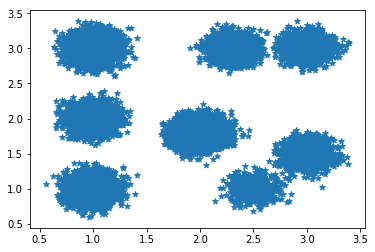

In [7]:
# а теперь попробуем решить другую, более сложную задачу:
# угадать карту локаций по координатам GPS-трекера и связь между ними

# сгеренируем данные, похожие на картинку с комнатами
# это будут центры кластеров
loc = [
    (1., 3.), (1., 2.),
    (2.3, 3.), (3., 3.),
    (3., 1.5), (2.5, 1.),
    (1., 1.), (2., 1.8)
]

# Этот приём называется data augmentation - раздутие выборки.
# Мы пропорционально поворяем данные, в некоторых методах это приводит к более точному решению,
# поскольку число итераций зависит от объёма данных
observations_augmented = observations * 100

from scipy.stats import norm
N = norm(0, 0.11)
# это шум, сформированный нормальным отклонением
noize = zip(N.rvs(size=len(observations_augmented)), N.rvs(size=len(observations_augmented)))

# получим для локаций зашумлённые координаты
points = []
for n, i in zip(noize, observations_augmented):
    x, y = loc[i-1][0] + n[0], loc[i-1][1] + n[1] 
    points.append((x, y))
points = np.array(points).T

plt.scatter(points[0,:], points[1,:], marker="*")
plt.show()

         1      -60511.8923             +nan
         2      -45620.5333      +14891.3590
         3      -33097.5605      +12522.9729
         4      -17732.3035      +15365.2569
         5        2075.9290      +19808.2325
         6        9692.9663       +7617.0374
         7       11444.2661       +1751.2998
         8       13597.0853       +2152.8192
         9       14589.3525        +992.2672
        10       15993.1729       +1403.8204
        11       17767.4373       +1774.2644
        12       17770.4758          +3.0385
        13       17770.4767          +0.0009


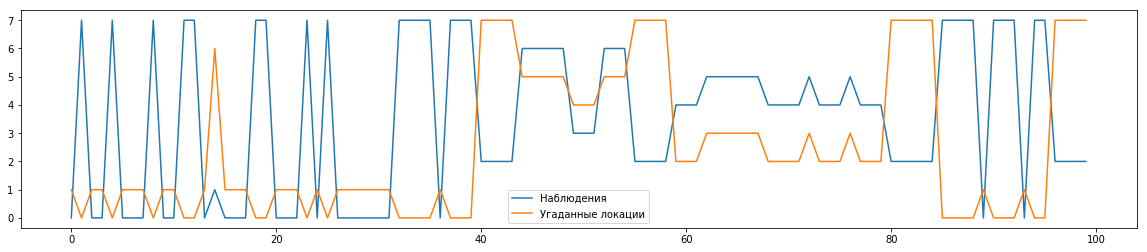

In [8]:
algorithm = GaussianHMM(
    n_components=location_count,  # число внутренних состояний - число локаций
    algorithm='viterbi',          # алгоритм подбора параметров
    n_iter=100,                   # число итераций
    verbose=True)                 # выводить отладочную информацию по итерациям

# выполним алгоритм Витерби
model = algorithm.fit(points.T)

# конечно, угаданные локации будут иметь другие номера
# но можно оценить по сменам состояний, что мы угадали всё почти точно
plt.figure(figsize=(20, 4))
plt.plot(model.predict(points.T)[:100])
plt.plot(observations_augmented[:100])
plt.legend(["Наблюдения", "Угаданные локации"])
plt.show()

In [9]:
# точно угадали все центры кластеров!
print("Средние значения кластеров")
print_matrix(model.means_)
print()

print("Матрица переходов между состояниями")
print_matrix(model.transmat_)
print()

Средние значения кластеров
	 [1] 	 [2] 	
<1>	1.00	3.00
<2>	2.50	1.01
<3>	1.00	1.00
<4>	3.00	3.00
<5>	1.00	2.00
<6>	2.30	3.00
<7>	3.00	1.50
<8>	2.00	1.80

Матрица переходов между состояниями
	 [1] 	 [2] 	 [3] 	 [4] 	 [5] 	 [6] 	 [7] 	 [8] 	
<1>	0.56	0.02	0.02	0.00	0.00	0.00	0.00	0.40
<2>	0.17	0.50	0.33	0.00	0.00	0.00	0.00	0.00
<3>	0.00	0.05	0.78	0.00	0.05	0.00	0.05	0.07
<4>	0.00	0.00	0.06	0.65	0.00	0.00	0.29	0.00
<5>	0.00	0.00	0.06	0.00	0.68	0.26	0.00	0.00
<6>	0.00	0.00	0.00	0.00	0.40	0.60	0.00	0.00
<7>	0.00	0.00	0.06	0.35	0.00	0.00	0.59	0.00
<8>	0.42	0.00	0.04	0.00	0.00	0.00	0.00	0.54



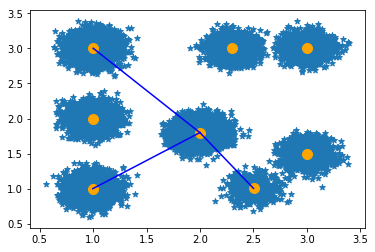

In [10]:
# посмотрим, где метод нашёл центроиды и какие связи обнаружил

# построим точки
plt.scatter(points[0,:], points[1,:], marker="*")
# построим центры найденных кластеров
plt.scatter(model.means_[:,0], model.means_[:,1], marker="o", color="orange", s=100)


# найдёт центроид 8-й локации, которая посередине помещения
closest = 0
point = loc[7]  # точка посередине
dist = float('+inf')
for i in range(location_count):
    d = (model.means_[i, 0] - point[0]) ** 2 + (model.means_[i, 1] - point[1]) ** 2
    if d < dist:
        closest = i
        dist = d

# это матрица значимых переходов, состоящая из логических значений
trans = (model.transmat_ > 1e-38)

# построим связи между кластером по центру и выявленными переходами
for i in range(location_count):
    # если есть вероятность перехода
    if (trans[i, closest] or trans[closest, i]) and i != closest:
        plt.plot(
            [model.means_[i, 0], model.means_[closest, 0]], 
            [model.means_[i, 1], model.means_[closest, 1]],
            c='b'
        )
        
plt.show()